# **Build your own PDF chatbot using Retrieval Augmented Generation**

**Using pretrained LLMs to interact with complex PDFs on your computer.**

Demonstrated below is a method to tinker with LlamaIndex and Mistral-7B-Instruct-v0.1 to build a smart agent (chatbot).

GitHub - https://github.com/neelblabla/pdf_chatbot_using_rag

## **Approach: Retrieval Augmented Generation**

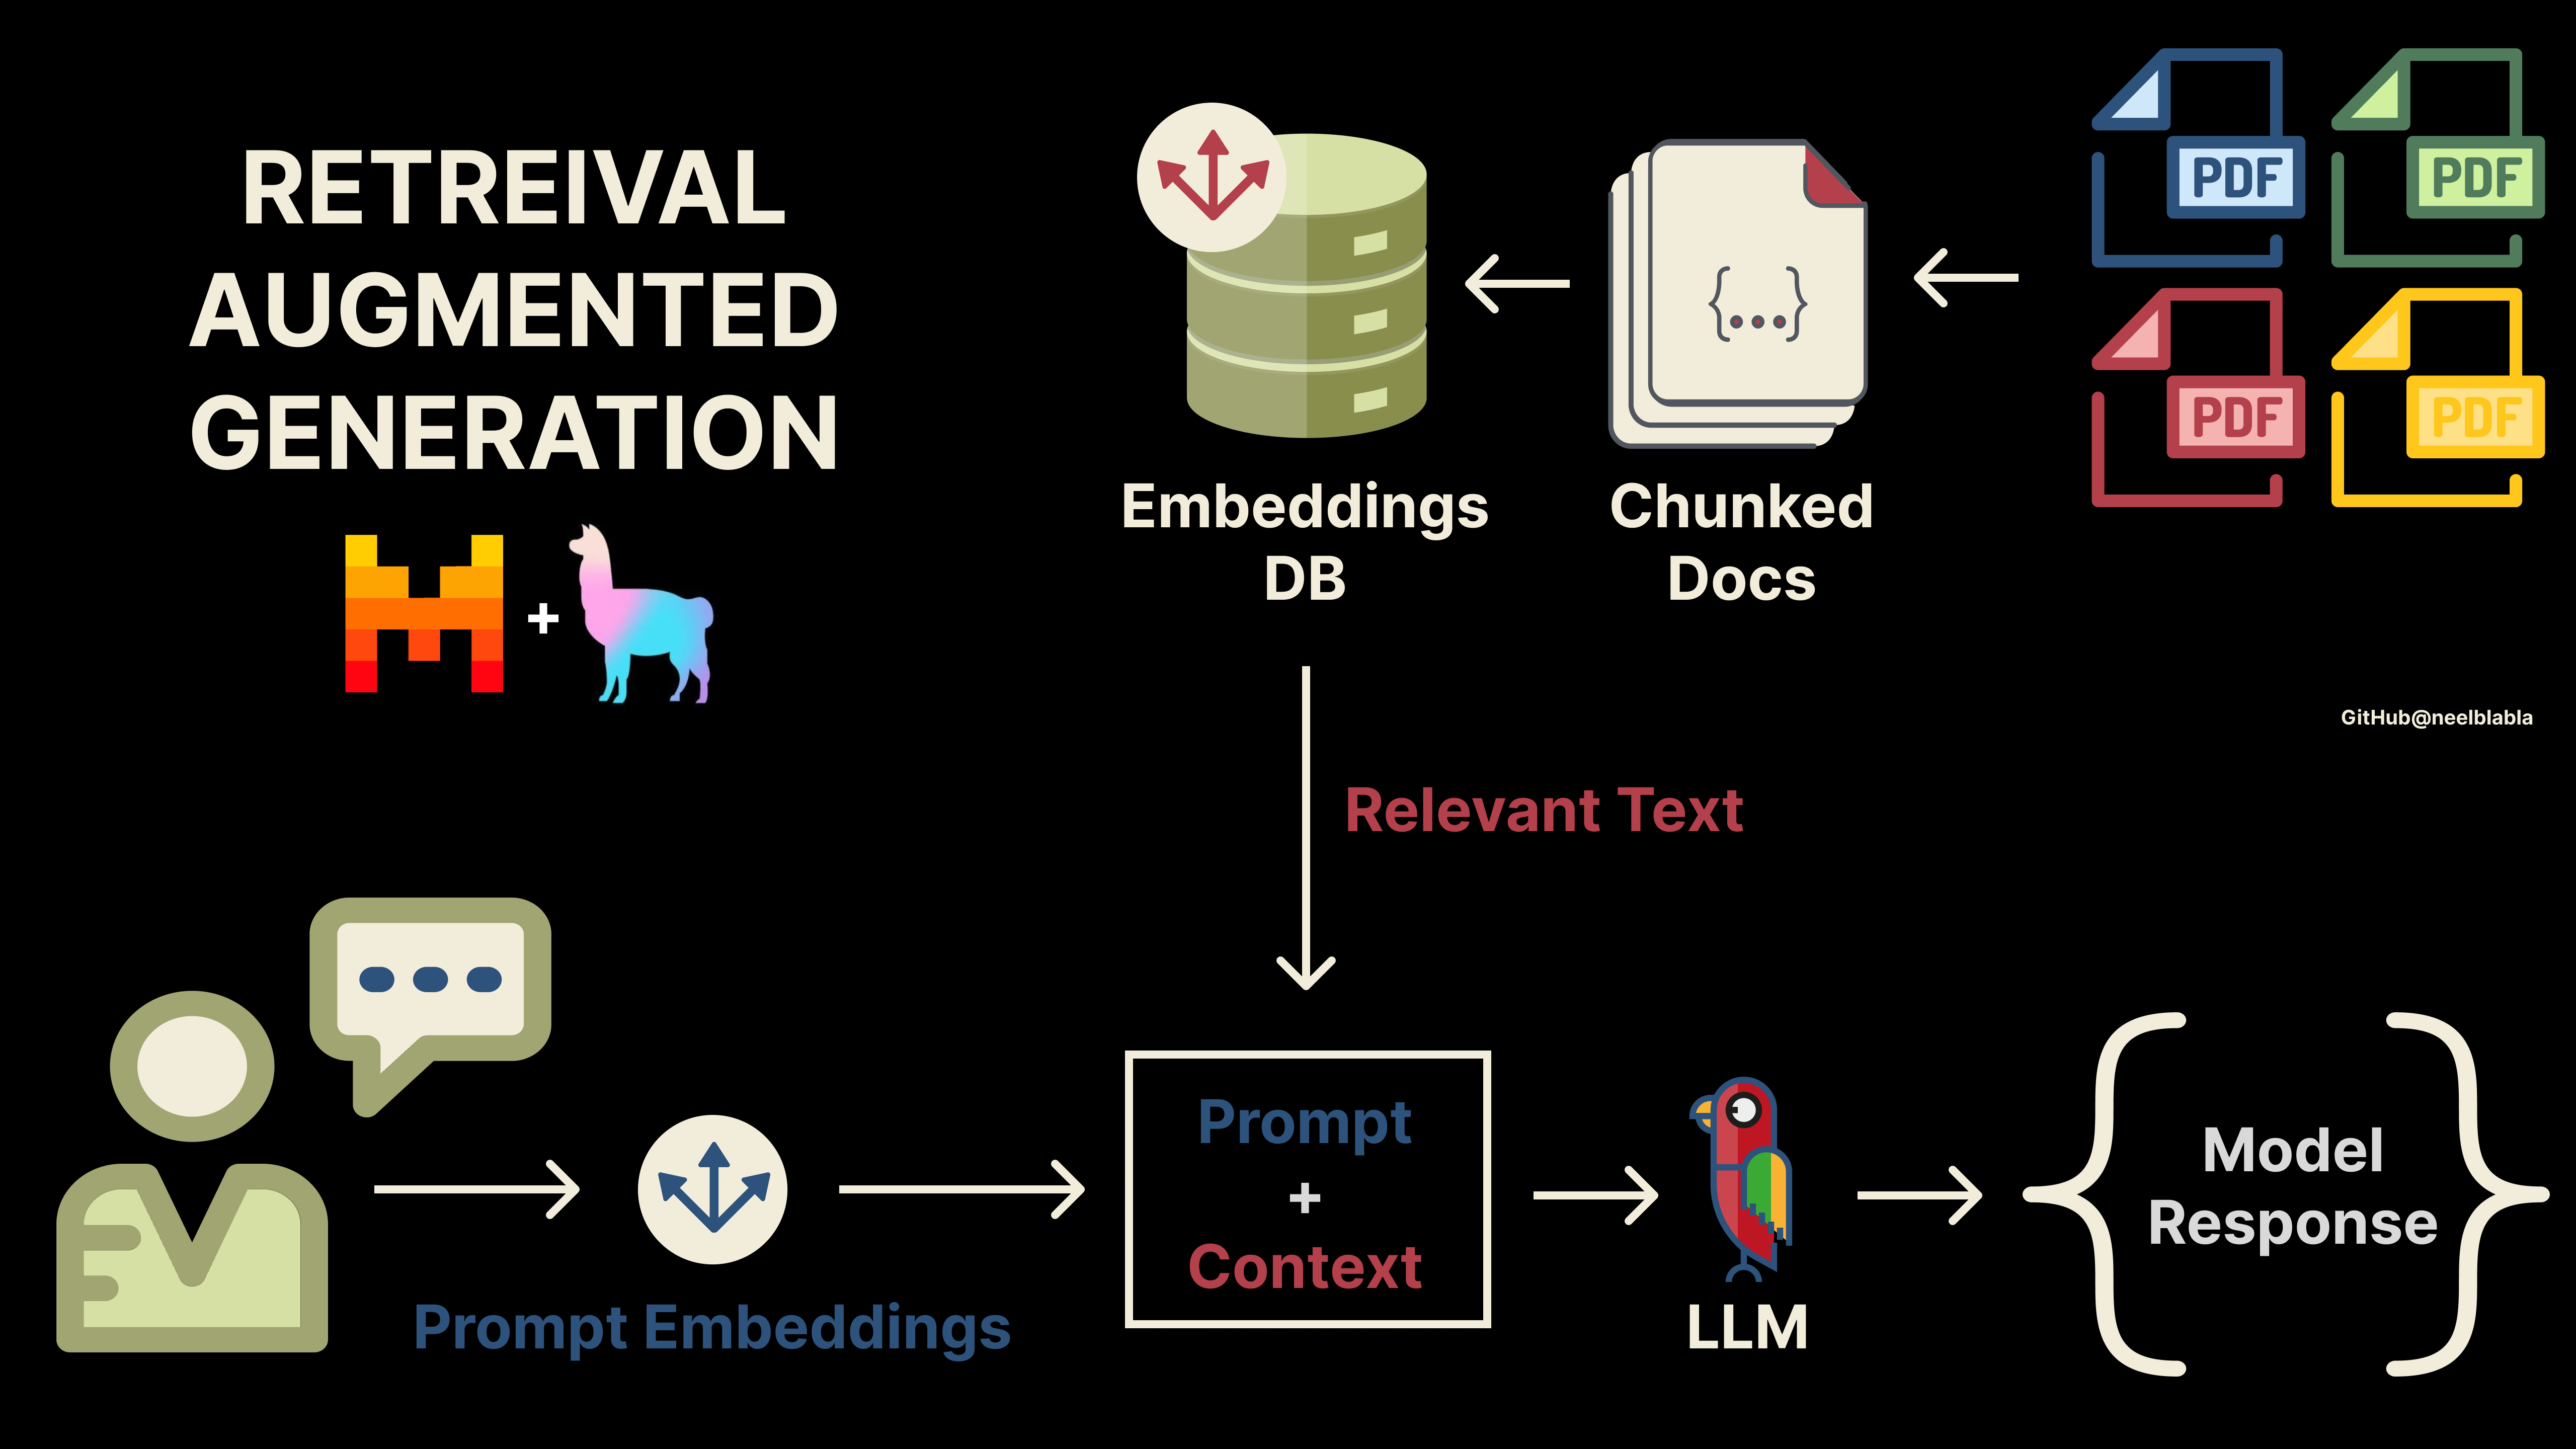

In [1]:
# @title
# RAG schematic
import requests
from PIL import Image
from io import BytesIO

url = "https://github.com/neelblabla/pdf_chatbot_using_rag/raw/main/RAG.png"
response = requests.get(url)

with Image.open(BytesIO(response.content)) as img:
    display(img)

The approach is two folds:
1. **Context retrieval** - This involves identifying chunks of texts, within the source documents and extracting them to generate context. This is achieved through retrieval augmentation. "LlamaIndex" is our choice of framework for retrieval and augmentation.

2. **Text generation** - This involves inferencing on LLM(s) to respond in a fashion such that the output is always derived from the information present within the context provided.

Advantages:
1. Data privacy is intact, since LLM is hosted locally
2. No commercial API based cost

In [2]:
%%capture
# let's display 'execution time' for each cell
!pip install ipython-autotime
%load_ext autotime

time: 1.31 ms (started: 2024-07-20 16:04:42 +00:00)


In [3]:
%%capture
# install dependencies
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install --upgrade transformers
!pip install --upgrade accelerate
!pip install --upgrade bitsandbytes
!pip install --upgrade pypdf

# install more dependencies
!pip install --upgrade llama-index
!pip install --upgrade llama-index-llms-huggingface
!pip install --upgrade llama-index-embeddings-huggingface

time: 2min 6s (started: 2024-07-20 16:04:42 +00:00)


In [4]:
%%capture
# import packages and libraries
import pandas as pd
from IPython.display import display
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer, BitsAndBytesConfig
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import ChatPromptTemplate
from llama_index.core.response.notebook_utils import display_response

time: 20.9 s (started: 2024-07-20 16:06:48 +00:00)


In [5]:
# HuggingFace login for accessing LLM
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful
time: 8.39 s (started: 2024-07-20 16:07:09 +00:00)


In [6]:
# load the Google drive helper and mount
# this is where we can store our PDF documents, content of which will provide context to the LLM
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 16.9 s (started: 2024-07-20 16:07:18 +00:00)


## **Choice of LLM - "Mistral-7B-Instruct-v0.1"**

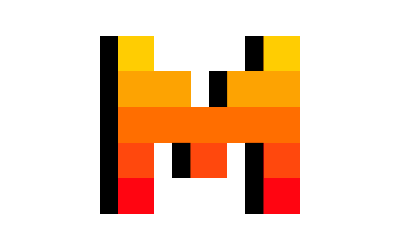

time: 649 ms (started: 2024-07-20 16:07:35 +00:00)


In [7]:
# @title
# Mistral logo
with Image.open("drive/My Drive/pdf_chatbot_using_rag/mistral_ai.png") as img:
  resized_img = img.resize((400,250))
  display(resized_img)

**"Mistral-7B-Instruct-v0.1" LLM**

1. State-of-the-art: released by MistralAI in H2'2023
2. Can be persisted locally on your own machines; parameter count = 7b (ChatGPT has 175b parameters)
3. Context window = 32.8k tokens
4. Requires minimal GPUs for inferencing. Fine-tuning is not computationally expensive
5. Good community support


In [8]:
# load large language model and define quantization parameters

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

Settings.llm = HuggingFaceLLM(
    model_name="mistralai/Mistral-7B-Instruct-v0.1",
    tokenizer_name="mistralai/Mistral-7B-Instruct-v0.1",
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    generate_kwargs={
        "do_sample":True, # Enables sampling, making the output more varied and less deterministic.
        "temperature": 0.3, # Low temperature makes the output more focused and less random; high temperature increases randomness.
        "top_k": 50, # Considers only the top 50 most probable next tokens, reducing the chance of unlikely words appearing.
        "top_p": 0.95 # Chooses from the smallest set of tokens whose cumulative probability is 95%, balancing between diversity and coherence.
        },
    device_map="cuda",
)

# model for Embeddings
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

time: 3min 12s (started: 2024-07-20 16:07:35 +00:00)


In [9]:
# we set up a QnA template

# mistral-instruct doesn't use the "system" role, so supply the context and question as a "user" message.
chat_text_qa_msgs = [
    (
        "user",
        """You are a well-behaved chatbot i.e. a Q&A assistant. Your goal is to answer questions as accurately as possible, exclusively based on the instructions and context provided.

Context:

{context_str}

Question:

{query_str}
""",
    )
]

text_qa_template = ChatPromptTemplate.from_messages(chat_text_qa_msgs)

time: 734 µs (started: 2024-07-20 16:10:48 +00:00)


## **Approach: Retrieval Augmented Generation**

In [16]:
# processing and displaying PDF documents
docs_path = f"drive/My Drive/pdf_chatbot_using_rag/PDFs/"
documents = SimpleDirectoryReader(docs_path).load_data() # load your data (PDFs)

# evaluating how doucuments were indexed
files_df = pd.DataFrame(columns = ['file_name', 'page_number'])
for i, document in enumerate(documents):
  files_df.loc[i] = [document.metadata['file_name'], document.metadata['page_label']]

# grouping dosuments with file names
docs_df = files_df.groupby("file_name").size().reset_index(name = 'number_of_pages')
total_pages = docs_df['number_of_pages'].sum()
docs_df = pd.concat([docs_df, pd.DataFrame({'file_name': ['TOTAL'], 'number_of_pages': [total_pages]})], ignore_index=True)

print(f"Number of documents processed = {len(docs_df['file_name'].unique()) - 1}")
print(f"Total number of pages indexed = {sum(docs_df['number_of_pages']) - total_pages}")
display(docs_df)

Number of documents processed = 2
Total number of pages indexed = 7


,file_name,number_of_pages
0,anecdotes_from_my_IIT_JEE_preparations.pdf,3
1,un_reforms_essay.pdf,4
2,TOTAL,7


time: 658 ms (started: 2024-07-20 16:13:15 +00:00)


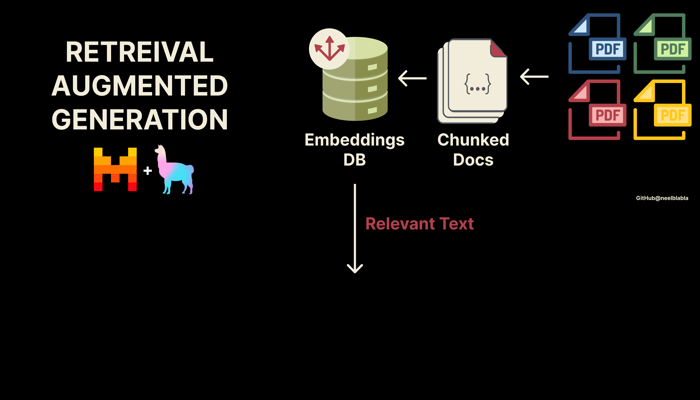

time: 425 ms (started: 2024-07-20 16:13:16 +00:00)


In [17]:
# @title
# RAG_INDEXING schematic
with Image.open("drive/My Drive/pdf_chatbot_using_rag/RAG_indexing.png") as img:
  resized_img = img.resize((700,400))
  display(resized_img)

In [18]:
# indexing (i.e. creating vector database)

vector_index = VectorStoreIndex.from_documents(documents)
print(f"Total number of pages (from all PDFs) covered in the vector database + {len(vector_index.ref_doc_info)}")

# exploring vector database
vector_dict = vector_index.ref_doc_info
vector_df = pd.DataFrame(columns = ['file_name', 'page_label', 'page_vector_ids', 'node_vector_ids', 'count_nodes'])
for i, page_vector_ids in enumerate(vector_dict):
  node_vector_ids = vector_dict[page_vector_ids].node_ids
  count_nodes = len(node_vector_ids)
  file_name = vector_dict[page_vector_ids].metadata['file_name']
  page_label = vector_dict[page_vector_ids].metadata['page_label']
  vector_df.loc[i] = [file_name, page_label, page_vector_ids, node_vector_ids, count_nodes]
print(f"Number of node vectors created in the database = {vector_df['count_nodes'].sum()}")
display(vector_df)

Total number of pages (from all PDFs) covered in the vector database + 7
Number of node vectors created in the database = 18


,file_name,page_label,page_vector_ids,node_vector_ids,count_nodes
0,anecdotes_from_my_IIT_JEE_preparations.pdf,1,6d893eb4-c9c3-47d4-bcee-e165fc3706d3,"[61ebc976-e5cd-4931-9e1a-c4d96a6cbe74, 265d15a...",2
1,anecdotes_from_my_IIT_JEE_preparations.pdf,2,432713ff-e7a7-4cf5-92a9-e3a8abc05a07,"[ae67f771-5666-4c8f-b838-8ca85b90bed7, 7394fcc...",3
2,anecdotes_from_my_IIT_JEE_preparations.pdf,3,88089d6d-341a-4a7f-8471-765a8e75309e,"[93d77e6c-4e99-4298-83ed-730a986eb233, 5a56f33...",3
3,un_reforms_essay.pdf,1,63e08a9e-800d-46ef-96b6-67aa32d1b652,"[29945de9-5ce9-47a1-b43d-aac9ddb7724d, 4398e4d...",3
4,un_reforms_essay.pdf,2,28b5cd80-35e1-4ac7-98be-66e20a069f76,"[2c11b7b1-8814-4d6c-aaed-180c4e350a99, a87eb98...",3
5,un_reforms_essay.pdf,3,61150d5f-f47b-4cae-9ed0-9b6497d47109,"[c44375ec-eba5-4389-a143-1250291e9b47, 3749b0a...",3
6,un_reforms_essay.pdf,4,5ae28c10-1865-4b1b-9282-de86b0073674,[b4d9e2d6-866e-4b61-91a3-3ba083abcbc0],1


time: 264 ms (started: 2024-07-20 16:13:16 +00:00)


In [19]:
# defining query engine

Settings.chunk_size = 512 # size of text chunks
Settings.chunk_overlap = 10
number_of_text_chunks_to_consider_in_context_for_one_prompt = 3 # number of text chunks to consider for constructing context for one prompt

query_engine = vector_index.as_query_engine(
    response_mode = 'compact', # this means that the query engine will generate concise, to-the-point responses, avoiding lengthy or detailed explanations
    similarity_top_k = number_of_text_chunks_to_consider_in_context_for_one_prompt,
    text_qa_template=text_qa_template
    )

time: 766 µs (started: 2024-07-20 16:13:17 +00:00)


In [23]:
# model response to human queries

human_query = "What stats about IIT-JEE are discussed in this document? Give me answer in 5 bullet points"
# human_query = "What were the most crucial learnings for the author in the process of preparation for IIT-JEE exam? Respond in 3 lines"
# human_query = "What key points has the author propsed for the UN reform? Answer in 3 to 4 lines."
response = query_engine.query(human_query)
display_response(response)


# exploring sources for model response
data_response_source_nodes = []
for source_node in response.source_nodes:
  data_response_source_nodes.append(
      {
          'file_name': source_node.metadata['file_name'],
          'page_label': source_node.metadata['page_label'],
          'score': "{:.3f}".format(source_node.score),
          'start_char_index': source_node.node.start_char_idx,
          'end_char_index': source_node.node.end_char_idx,
          'len_text': len(source_node.node.text),
          'word_count': len(source_node.node.text.split()),
          'text': source_node.node.text,
      }
  )
df_response_source_nodes = pd.DataFrame(data_response_source_nodes)
display(df_response_source_nodes)

**`Final Response:`** 1. IIT-JEE is the toughest Engineering Entrance Examination not only in India but across the globe.
2. It is conducted by the Indian Institute of Technology and sees participation from 4,85,000 students competing to secure the top 5,000 seats in the most sought-after prestigious chain of 7 IITs (public Engineering institutions).
3. The success rate is less than 1%.
4. An entire coaching industry has surfaced up in parts of India due to the advanced syllabus of the exam, which is significantly advanced from what is taught in schools.
5. Kota, a small town in west India, is the hotspot for IIT-JEE preparations, with students from across the country migrating to Kota for two years to prepare for the exam. Kota's infrastructure is so mature that it never fails to deliver top 10 ranks in the IIT-JEE exam year after year.

,file_name,page_label,score,start_char_index,end_char_index,len_text,word_count,text
0,anecdotes_from_my_IIT_JEE_preparations.pdf,1,0.784,0,1035,1035,182,My\nIIT\nJEE\npreparations\nand\nthe\nquest\nt...
1,anecdotes_from_my_IIT_JEE_preparations.pdf,1,0.743,1036,2034,998,152,-\nThe\nhotspot\nis\nKota\n-\na\nsmall\ntown\n...
2,anecdotes_from_my_IIT_JEE_preparations.pdf,2,0.727,1057,2082,1025,200,"-\nSomehow,\nI\nrealized\nthe\npower\nof\npers..."


time: 20.8 s (started: 2024-07-20 17:01:49 +00:00)
